In [47]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
from typing import List

In [48]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [49]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [50]:
# build the dataset
BLOCK_SIZE = 8 # context length: how many characters do we take to predict the next one?
ALPHABET_SIZE = 27
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [51]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBEDDING_SIZE = 10 # the dimensionality of the character embedding vectors
HIDDEN_SIZE = 68 # the number of neurons in the hidden layer of the MLP

In [52]:
class Embedding:
    def __init__(self, n, size):
        self.embedding_table = torch.randn((n, size), generator=g)
    
    def __call__(self, x):
        self.out = self.embedding_table[x]
        return self.out
    
    def parameters(self):
        return [self.embedding_table]

In [53]:
class Flatten:
    def __init__(self, n):
        self.n = n

    def __call__(self, x: torch.Tensor):
        a, b, c = x.shape
        self.out = x.view(a, b // self.n, c * self.n)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out
    
    def parameters(self):
        return []

In [54]:
class Linear:
    def __init__(self, n_input, n_output, bias=True):
        self.W = torch.randn((n_input, n_output), generator=g) * (5/3) / (n_input ** 0.5)
        self.b = torch.randn(n_output, generator=g) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self) -> List[torch.Tensor]:
        params = [self.W]
        if self.b is not None:
            params.append(self.b)
        return params

In [55]:
class BatchNorm1D:
    def __init__(self, n):
        self.gain = torch.ones((1, n))
        self.bias = torch.zeros((1, n))
        self.running_mean = torch.zeros((1, n))
        self.running_stddev = torch.ones((1, n))
        self.training = True

    def __call__(self, x: torch.Tensor):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            mean = x.mean(dim, keepdim=True)
            std = x.std(dim, keepdim=True)
        else:
            mean = self.running_mean
            std = self.running_stddev

        self.out = self.gain * (x - mean) / std + self.bias
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * 0.9 + mean * 0.1
                self.running_stddev = self.running_stddev * 0.9 + std * 0.1
        return self.out

    def parameters(self) -> List[torch.Tensor]:
        return [self.gain, self.bias]


In [56]:
class Tanh: 
    def __call__(self, x: torch.Tensor):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []

In [57]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x: torch.Tensor):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if torch.isnan(x).any():
                print(f"after layer {i}", layer.__class__.__name__, x)

        self.out = x
        return self.out

    def parameters(self) -> List[torch.Tensor]:
        return [p for l in self.layers for p in l.parameters()]

In [58]:
EMBEDDING_SIZE = 32
model = Sequential([
    Embedding(ALPHABET_SIZE, EMBEDDING_SIZE), Flatten(2),
    Linear(2 * EMBEDDING_SIZE, HIDDEN_SIZE, bias=False), BatchNorm1D(HIDDEN_SIZE), Tanh(), Flatten(2),
    Linear(2 * HIDDEN_SIZE, HIDDEN_SIZE, bias=False), BatchNorm1D(HIDDEN_SIZE), Tanh(), Flatten(2),
    Linear(2 * HIDDEN_SIZE, HIDDEN_SIZE, bias=False), BatchNorm1D(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, ALPHABET_SIZE), 
])
print(sum(p.nelement() for p in model.parameters()))
for param in model.parameters():
    param.requires_grad = True

25983


In [59]:
def step(X, Y, step_count):

    batch_size = 32
    idxs = torch.randint(0, X.shape[0], (batch_size,))
    X_batch = X[idxs]
    Y_batch = Y[idxs]

    out = model(X_batch)
    loss = F.cross_entropy(out, Y_batch)

    for param in model.parameters():
        param.grad = None

    loss.backward()

    learning_rate = 0.1 if step_count < 150_000 else 0.01
    for param in model.parameters():
        param.data += -learning_rate * param.grad
    
    return loss

In [60]:
stepi = []
lossi = []

In [61]:
for i in range(200_000):
    stepi.append(len(stepi) + 1)
    loss = step(Xtr, Ytr, stepi[-1])
   
    if stepi[-1] % 1000 == 0:
        print("step %d, loss %f" % (stepi[-1], loss.item()))
    lossi.append(loss.item())

step 1000, loss 2.603112
step 2000, loss 2.506932
step 3000, loss 2.171036
step 4000, loss 2.266336
step 5000, loss 2.086301
step 6000, loss 2.319451
step 7000, loss 2.658152
step 8000, loss 1.928839
step 9000, loss 2.276294
step 10000, loss 1.976432
step 11000, loss 2.158509
step 12000, loss 2.117121
step 13000, loss 2.265384
step 14000, loss 2.402553
step 15000, loss 2.450399
step 16000, loss 2.043481
step 17000, loss 1.939764
step 18000, loss 1.993284
step 19000, loss 1.753098
step 20000, loss 1.628404
step 21000, loss 1.957647
step 22000, loss 2.248777
step 23000, loss 1.955052
step 24000, loss 2.194534
step 25000, loss 1.818794
step 26000, loss 2.209824
step 27000, loss 1.705252
step 28000, loss 2.500230
step 29000, loss 1.785326
step 30000, loss 2.102908
step 31000, loss 2.220608
step 32000, loss 1.987384
step 33000, loss 2.133028
step 34000, loss 2.031842
step 35000, loss 2.227248
step 36000, loss 2.313585
step 37000, loss 1.814889
step 38000, loss 1.954242
step 39000, loss 2.01

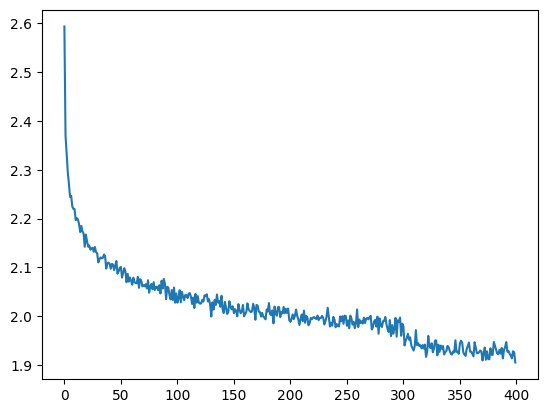

In [62]:
plt.plot(torch.tensor(lossi).view(-1, 500).mean(1))



In [63]:
# turn training off for BatchNorm layers before inference / loss calculation
for layer in model.layers:
    if isinstance(layer, BatchNorm1D):
        layer.training = False

In [64]:
def calculate_loss(X: torch.Tensor, Y: torch.Tensor):
    with torch.no_grad():
        out = model(X)
        loss = F.cross_entropy(out, Y)
        print(loss.item())        

In [65]:
calculate_loss(Xtr, Ytr)
calculate_loss(Xdev, Ydev)
calculate_loss(Xte, Yte)

1.899675726890564
2.01582932472229
2.01283597946167


In [66]:
for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)

Embedding torch.Size([22866, 8, 32])
Flatten torch.Size([22866, 4, 64])
Linear torch.Size([22866, 4, 68])
BatchNorm1D torch.Size([22866, 4, 68])
Tanh torch.Size([22866, 4, 68])
Flatten torch.Size([22866, 2, 136])
Linear torch.Size([22866, 2, 68])
BatchNorm1D torch.Size([22866, 2, 68])
Tanh torch.Size([22866, 2, 68])
Flatten torch.Size([22866, 136])
Linear torch.Size([22866, 68])
BatchNorm1D torch.Size([22866, 68])
Tanh torch.Size([22866, 68])
Linear torch.Size([22866, 27])
